<h2>PRÁCTICA 2 - FUNDAMENTOS DE APRENDIZAJE AUTOMÁTICO</h1>
<h3>Realizada la práctica por:<br/>
    <ol>
    - Pablo Díez del Pozo<br/>
    - Alejandro Alcalá Álvarez<br/>
   </ol>
 </h3>


<h3>Código</h3>

En las siguientes celdas se inserta todo el código desarrollado para poder completar el funcionamiento requerido de la práctica.

<p>La clase <b>Datos</b> es idéntica a la que desarrollamos para la <b>Práctica 0</b>, con dos funciones añadidas, muy importantes para el correcto funcionamiento de el clasificador de <b>Vecinos Próximos</b>. Estas funciones son las siguientes:</p>
<ol> 
    <li><b>calcularMediasDesv(self, datos):</b> esta función permite calcular las medias y desviaciones típicas de cada uno de los atributos del dataset.3
    <li><b>normalizarDatos(self, datos):</b> llama a la función anterior y utiliza los valores que hemos calculado para normalizar el dataset, únicamente los valores continuos, ya que los discretos no es necesario normalizarlos
       

In [183]:
import numpy as np

class Datos:
    TiposDeAtributos = ('Continuo', 'Nominal')

    # TODO: procesar el fichero para asignar correctamente las variables tipoAtributos, nombreAtributos, nominalAtributos, datos y diccionarios
    # NOTA: No confundir TiposDeAtributos con tipoAtributos
    def __init__(self, nombreFichero):

        with open(nombreFichero, "r") as f:
            # Guardamos el numero de datos que contiene el DataSet y esta en la primera linea
            self.numDatos = int(f.readline())

            # Guardamos el nombre de los atributos
            self.nombreAtributos = f.readline().strip('\n').split(',')
            # print(self.nombreAtributos)

            # Leemos el tipo de los atributos de las variables y eliminamos el ultimo que es un salto de linea
            self.tipoAtributos = f.readline().strip('\n').split(',')
            # print(self.tipoAtributos)

            # Comprobamos que todos los atributos sean Continuos o Nominales
            if any(atr not in Datos.TiposDeAtributos for atr in self.tipoAtributos):
                raise ValueError("Tipo de atributo erroneo")

            # Segun el atributo, asignamos True o False.
            self.nominalAtributos = []

            # Guardamos en la lista nominalAtributos en la posicion de cada uno si es o no Nominal
            for tipo in self.tipoAtributos:
                if tipo == self.TiposDeAtributos[0]:
                    self.nominalAtributos.append(False)
                else:
                    self.nominalAtributos.append(True)


            # Guardamos los datos del fichero y los formateamos, de tal forma que cada linea es una lista
            datos = f.readlines()
            datosFormat = []
            for lista in datos:
                datosFormat.append(lista.strip('\n').split(','))

            listaDatosAtributos = []
            for i in range(len(self.tipoAtributos)):
                listaDatosAtributos.append([])

            # Hacemos la traspuesta de los datos que guardamos para que cada lista de atributo guarde todos los datos
            # de cada atributo.
            for lista in datosFormat:
                i = 0
                for item in lista:
                    listaDatosAtributos[i].append(item)
                    i += 1

            # Ordenamos y hacemos un set para eliminar repetidos.
            i = 0
            for item in listaDatosAtributos:
                listaDatosAtributos[i] = sorted(set(item))
                i += 1

            # Creacion de lista diccionarios, en caso de que el atributo sea Continuo, el diccionario estara vacio
            self.listaDicts = []
            for i in range(len(self.tipoAtributos)):
                self.listaDicts.append({})

            # Creamos el diccionario tal y como se describe en las diapositivas, por orden y asignando valores numericos crecientes
            i = 0
            for atributo in listaDatosAtributos:
                k = 0
                if self.tipoAtributos[i] == "Nominal":
                    for dato in atributo:
                        self.listaDicts[i][dato] = k
                        k += 1
                i += 1

            # Creacion de la matriz de datos utilizando el diccionario para mapear los valores
            # En primer lugar, creamos una matriz vacia de tamaña numero de atributos.
            self.datos = np.empty((int(self.numDatos), int(len(self.tipoAtributos))))
            i = 0
            j = 0

            # Metemos los datos en la matriz, mapeando con los diccionarios en el caso de que sean Nominales, y si son continuos normal.
            for i in range(int(self.numDatos)):
                for j in range(len(self.tipoAtributos)):
                    if self.tipoAtributos[j] == 'Nominal':
                        self.datos[i][j] = self.listaDicts[j].get(str(datosFormat[i][j]))
                    else:
                        self.datos[i][j] = datosFormat[i][j]

            f.close()

    # TODO: implementar en la practica 1
    def extraeDatos(self, idx):
        return self.datos[idx]


    def calcularMediasDesv(self,datos):

        # datosTrain es la matriz directamente, no hay que extraer nada
        # Se calcula la desv. tipica y la media para los atributos continuos

        # Creamos una lista con los indices que son continuos para calcular la media y desv tipica sobre ellos.
        self.indicesContinuos = []
        for i in range(len(self.nominalAtributos)):
            if self.nominalAtributos[i] == False:
                self.indicesContinuos.append(i)

        # Matriz que guarda el valor por atributo de la desv. tipica y la media
        estadisticas = np.zeros((2,len(self.nominalAtributos)))

        # Calculamos la desv tipica y media de los indices continuos sobre todos los datos que recibimos por param.
        for i in self.indicesContinuos:
            estadisticas[0,i] = np.mean(datos[:,i])
            estadisticas[1,i] = np.std(datos[:,i])

        return estadisticas


    def normalizarDatos(self, datos):

        estadisticas = self.calcularMediasDesv(datos)

        # Normalizamos los datos
        for i in self.indicesContinuos:
            datos[:,i] -= estadisticas[0,i]
            datos[:,i] /= estadisticas[1,i]

        return datos, estadisticas

La siguiente clase, <b>EstrategiaParticionado</b>, es exactamente igual que en la práctica anterior:

In [184]:
from abc import ABCMeta,abstractmethod

from abc import ABCMeta, abstractmethod
import numpy as np


class Particion():

  # Esta clase mantiene la lista de �ndices de Train y Test para cada partici�n del conjunto de particiones
  def __init__(self, train=[], test=[]):
    self.indicesTrain = train
    self.indicesTest = test

  def __str__(self):
    return "Train: {}\nTest:  {}".format(str(self.indicesTrain), str(self.indicesTest))


class EstrategiaParticionado:
  # Clase abstracta
  __metaclass__ = ABCMeta

  # Lista de las particiones
  def __init__(self, nombre=""):
    self.nombreEstrategia = nombre
    self.numeroParticiones = 0
    self.particiones = []

  # Atributos: deben rellenarse adecuadamente para cada estrategia concreta: nombreEstrategia, numeroParticiones, listaParticiones. Se pasan en el constructor

  @abstractmethod
  # TODO: esta funcion deben ser implementadas en cada estrategia concreta
  def creaParticiones(self, datos, seed=None):
    pass


class ValidacionSimple(EstrategiaParticionado):

  def __init__(self, porcentaje):
    self.porcentaje = porcentaje
    super().__init__("Validacion simple")

  # Crea particiones segun el metodo tradicional de division de los datos segun el porcentaje deseado.
  # Devuelve una lista de particiones (clase Particion)
  # TODO: implementar
  def creaParticiones(self, datos, seed=None):
    np.random.seed(seed)
    self.numeroParticiones = 1

    # Generamos una lista con todos los números de datos aleatorios
    indicesAleatorios = np.random.permutation(int(datos.numDatos))

    # Creamos la particion, en funcion del porcentaje especificado
    self.particiones = [Particion(indicesAleatorios[:int(datos.numDatos * self.porcentaje)],
                                  indicesAleatorios[int(datos.numDatos * self.porcentaje):])]

    return self.particiones


class ValidacionCruzada(EstrategiaParticionado):

  # Crea particiones segun el metodo de validacion cruzada.
  # El conjunto de entrenamiento se crea con las nfolds-1 particiones y el de test con la particion restante
  # Esta funcion devuelve una lista de particiones (clase Particion)
  # TODO: implementar

  def __init__(self, k):
    self.k = k
    super().__init__("Validacion cruzada")

  def creaParticiones(self, datos, seed=None):

    np.random.seed(seed)

    self.numeroParticiones = self.k

    # Generamos una lista con todos los números de datos aleatorios
    indicesAleatorios = np.random.permutation(int(datos.numDatos))

    # Hallamos el tamaño de cada bloque
    tamBloque = int(datos.numDatos / self.k)

    datosSobran = datos.numDatos - (tamBloque * self.k)
    count = 0
    for i in range(self.k):

      train = np.delete(indicesAleatorios, range(i * tamBloque, (i + 1) * tamBloque))
      test = indicesAleatorios[i * tamBloque:(i + 1) * tamBloque]

      # Caso en el que la cuenta es justa
      if datosSobran == 0:
        self.particiones.append(Particion(train, test))

      # Contemplamos el caso de que la division para sacar el numero de subconjuntos no fuese entera
      if datosSobran > 0:
        count += 1
        particionTest = np.append(test, train[(datos.numDatos - tamBloque) - i - 1])
        particionTrain = np.delete(train, (datos.numDatos - tamBloque) - i - 1)
        datosSobran -= 1
        self.particiones.append(Particion(particionTrain, particionTest))

A continuación, tenemos la clase <b>Clasificador</b>, junto con <b>ClasificadorNaiveBayes</b>, idénticas a las de la práctica 1:

In [185]:
from abc import ABCMeta,abstractmethod
import numpy as np
import math
from collections import Counter
from sortedcontainers import SortedDict
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from numpy import linalg as LA
from statistics import mode

class Clasificador:
  # Clase abstracta
  __metaclass__ = ABCMeta

  # Metodos abstractos que se implementan en casa clasificador concreto
  @abstractmethod
  # TODO: esta funcion debe ser implementada en cada clasificador concreto
  # datosTrain: matriz numpy con los datos de entrenamiento
  # atributosDiscretos: array bool con la indicatriz de los atributos nominales
  # diccionario: array de diccionarios de la estructura Datos utilizados para la codificacion de variables discretas
  def entrenamiento(self, datos, datosTrain, atributosDiscretos, diccionario):
    pass

  @abstractmethod
  # TODO: esta funcion debe ser implementada en cada clasificador concreto
  # devuelve un numpy array con las predicciones
  def clasifica(self, datosTest, atributosDiscretos, diccionario):
    pass

  # Obtiene el numero de aciertos y errores para calcular la tasa de fallo
  # TODO: implementar
  def error(self, datos, pred):
    # Aqui se compara la prediccion (pred) con las clases reales y se calcula el error
    i = 0
    real = datos[:, -1]
    error = 0
    for i in range(len(real)):
      if real[i] != pred[i]:
        error += 1
    err = (error) / (len(real) + 0.0)
    return err

  # Realiza una clasificacion utilizando una estrategia de particionado determinada
  # particionado : estrategia de validacion que queremos utilizar
  # dataset : clase de tipo Datos que utilizamos para entrenar y clasificar el modelo
  # clasificador: instancia del clasificador que se va a usar
  # TODO: implementar esta funcion
  def validacion(self, particionado, dataset, clasificador, seed: object = None):

    # Creamos las particiones siguiendo la estrategia llamando a particionado.creaParticiones
    # - Para validacion cruzada: en el bucle hasta nv entrenamos el clasificador con la particion de train i
    # y obtenemos el error en la particion de test i
    # - Para validacion simple (hold-out): entrenamos el clasificador con la particion de train
    # y obtenemos el error en la particion test. Otra opci�n es repetir la validaci�n simple un n�mero especificado de veces, obteniendo en cada una un error. Finalmente se calcular�a la media.
    errores = 0
    # particionado.creaParticiones(dataset, seed)
    # Comprobamos si es por validación cruzada o simple, por la longitud de la lista de particiones
    particionado.particiones = []
    particionado.creaParticiones(dataset)

    # Validación Simple
    if len(particionado.particiones) == 1:
      clasificador.entrenamiento(dataset, particionado.particiones[0].indicesTrain)
      pred = clasificador.clasifica(dataset.datos, particionado.particiones[0].indicesTest)
      ret = self.error(dataset.extraeDatos(particionado.particiones[0].indicesTest), pred)
      if ret > 0:
        return ret
      else:
        return 0

    # Validación Cruzada
    else:
      lista_error = []
      for particion in particionado.particiones:
        clasificador.entrenamiento(dataset, particion.indicesTrain)
        pred = clasificador.clasifica(dataset.datos, particion.indicesTest)
        ret = self.error(dataset.extraeDatos(particion.indicesTest), pred)
        lista_error.append(ret)
      return np.mean(lista_error), np.std(lista_error)

  def matrizConfusion(self, dataset, datosTest, prediccion):

    # Calculamos la matriz de confusion utlizando sk-learn. Solo se calcula en el caso de que la clasificacion sea binaria.
    testData = dataset.extraeDatos(datosTest)
    clase_real = testData[:, -1]

    matriz = confusion_matrix(prediccion, clase_real)

    # La funcion ravel() devuelve todas las estadisticas relacionadas con la matriz de confusion
    tn, fp, fn, tp = matriz.ravel()

    # Calculamos las tasas extraídas de la matriz de confusión
    tpr = tp / (tp + fn)
    fpr = fp / (fp + fn)

    self.lista_tpr.append(tpr)
    self.lista_fpr.append(fpr)

    return matriz

  def curvaROC(self):

    x = np.linspace(0, 1, 100)
    plt.plot(x, x, c='blue')
    for i in range(len(self.lista_fpr)):
      plt.plot(self.lista_fpr[i], self.lista_tpr[i], 'ro')
    plt.show()

class ClasificadorNaiveBayes(Clasificador):

  def __init__(self, laplace):
    self.laplace = laplace
    self.lista_fpr = []
    self.lista_tpr = []

  def entrenamiento(self, dataset, datosTrain):

    # Cargamos todos los datos de la clase del dataset desde la matriz de datos
    clasesTrain = dataset.extraeDatos(datosTrain)
    self.numClases = clasesTrain[:, -1]

    # Contamos las apariciones de cada uno para luego calcular la probabilidad a priori de cada clase
    counter = Counter(self.numClases)

    # Calculamos la probabilidad de la clase y lo metemos en un diccionario ordenado segun el numero
    # correspondiente a cada clase asignado en el diccionario
    self.dictPrioris = {}
    for k in counter:
      k = int(k)
      counter[k] = counter[k] / len(self.numClases)
      self.dictPrioris[k] = counter[k]

    # Aqui ordenamos el diccionario para que esten en el mismo orden de como extraemos los datos del dataset
    self.dictPrioris = SortedDict(self.dictPrioris)

    # Calcular tablas de probabilidades del entrenamiento. Tenemos que calcular por cada atributo una cuenta
    # de las apariciones en cada clase
    # Creamos una lista de matrices, donde vamos almacenar todos los datos que hemos obtenido en los datos de Test
    self.posteriori = np.zeros(len(dataset.nombreAtributos) - 1, dtype=object)

    # Recorremos todos los datos de la matriz sin llegar a la clase
    for i in range(len(dataset.nombreAtributos) - 1):

      # Si el dato que obtenemos es Nominal haremos el recuento de todas las veces que sale la P(D|H)
      if dataset.nominalAtributos[i] == True:

        # Creamos una matriz de tamaño X: Número de Atributos menos la clase Y: Número de clases
        post = np.zeros((len(dataset.listaDicts[i]), len(dataset.listaDicts[-1])))

        # Aqui contamos todos las datos que queremos del datos Train para construir la matriz de entrenamiento
        for c in range(len(dataset.listaDicts[-1])):
          datosEnt = dataset.extraeDatos(datosTrain)
          dat = datosEnt[:, i]
          repes = Counter(dat[datosEnt[:, -1] == c])
          for r in repes:
            post[int(r), c] = repes[r]
          if self.laplace == True:
            self.posteriori[i] = post + 1
          else:
            self.posteriori[i] = post

      # Si el dato es Continuo obtendremos la media y la desviación tipica de la clase
      else:

        # Creamos una matriz de X: Los datos de Media y Desivación típica Y: Número de clases
        post = np.zeros((2, len(dataset.listaDicts[-1])))

        # Aqui obtenemos la media y desviación tipica de cada clase, despues de tener los datos de entrenamiento
        for c in range(len(dataset.listaDicts[-1])):
          datosEnt = dataset.extraeDatos(datosTrain)
          dat = datosEnt[:, i]
          datos = dat[datosEnt[:, -1] == c]
          post[0][c] = np.mean(datos)
          post[1][c] = np.std(datos)
        self.posteriori[i] = post


    # Calculamos los valores de los posteriori de todos las tablas anteriores
    for i in range(len(dataset.listaDicts) - 1):
      if dataset.nominalAtributos[i] == True:
        self.posteriori[i] /= sum(self.posteriori[i])

  def clasifica(self, dataset, datosTest):
    acum_probs = 1
    self.prediccion = []
    datTest = dataset[datosTest]

    # Ahora vamos a estudiar la probabilidad de la clase con los datos obtenidos en el entrenamiento
    # Recorremos todos las datos de la matriz de los datos Test
    for dato in datTest:
      mapa = []
      # Aqui obtenemos los prioris de cada clase para poder obtener la probabilidad de cada una
      for clase in range(len(self.dictPrioris)):
        listaVerosimilitudes = []
        # Aqui obtenemos cada valor posteriori de nuestro entrenamiento de los datos, es decir, P(D|H)
        for atributo in range(len(self.posteriori)):
          if dataset.nominalAtributos[atributo] == True:
            prob = self.posteriori[atributo][int(dato[atributo])][clase]
            listaVerosimilitudes.append(prob)

          # Aqui obtenemos la probabilidad de los atibutos continuos
          else:
            # Hacemos la formula de la distribucion normal
            exp1 = 1 / (self.posteriori[atributo][1][clase] * math.sqrt(2 * math.pi))
            exp2 = np.power((dato[atributo] - self.posteriori[atributo][0][clase]), 2)
            exp3 = np.power(self.posteriori[atributo][1][clase], 2)
            exp4 = exp2 / exp3
            exp4 = math.exp((-1 / 2) * exp4)
            prob = exp1 * exp4
            listaVerosimilitudes.append(prob)

        for verosimilitud in listaVerosimilitudes:
          acum_probs *= verosimilitud
        acum_probs *= self.dictPrioris.get(clase)
        mapa.append(acum_probs)
        acum_probs = 1

      # Aqui obtenemos la predicción de mayor probabilidad y la guardamos en nuestra lista de predicciones
      self.prediccion.append(np.argmax(mapa))


    # Devolvemos la lista con la predicción de nuestro clasifica
    return self.prediccion

En las siguientes celdas aparecen las clases <b>ClasificadorVecinosProximos</b> y <b>ClasificadorRegresionLogistica</b>, ambas necesarias para la funcionalidad requerida en esta práctica.

La clase <b>ClasificadorVecinosProximos</b> recibe como parámetros en su constructor tanto el valor de <b>K</b>y si se quiere normalizar el dataset o no, por defecto la normalización está activada. El método <b>entrenamiento()</b>, normaliza el dataset si tenemos esa opción a True y guarda los datos de entrenamiento. En el caso de que no queremos normalizar, simplemente guarda los datos de entrenamiento. El método <b>clasifica()</b> implementa el algoritmo de <b>Vecinos Próximos</b>, calculando las distancias de los datos de Test con todos los datos de Train y quedandose con la clase mayoritaría de los k elementos con menor distancia, para cada dato del conjunto de Test. Todo lo anterior genera una lista con las clases predichas, que es lo que devuelve la función.

La clase <b>ClasificadorRegresionLogistica</b> se inicializa con dos parámetros, la <b>Constante de Aprendizaje</b>, que se utiliza para actualizar la función de pesos del método <b>entrenamiento()</b>, y el <b>número de épocas</b>. Además, cuenta con una función auxiliar <b>sigmoidal()</b> que ejecuta la sigmoidal del valor dado por el producto escalar de la función de pesos <b>(w)</b> y el vector compuesto por el dato de entrenamiento <b>(x)</b> en el que nos encontramos. La función <b>entrenamiento()</b> utiliza el algoritmo de la Regresión Logistica hasta el número de épocas definido, obteniendo el vector de pesos final, que posteriormente se utiliza en <b>clasifica()</b>, que genera una predicción para cada dato del test, aplicando la sigmoidal del dato multiplicado por el vector de pesos final que obtenemos al entrenar el modelo, si se obtiene un valor mayor de 0.5 el dato es de clase 1, si no de clase 2. 

<h4>Particularidades Vecinos Próximos</h4>

No hemos realizado distinción entre el caso de que el atributo sea discreto o continuo para calcular las distancias, ya que nuestra idea era utilizar distancia Euclídea en el caso de los continuos y distancia Manhattan en el caso de los discretos, pero como codificamos el dataset previamente en formato numérico, esas distancias no se ven afectadas realizando la distinción, ya que son proporcionales.

El caso en el que el atributo tiene un orden natural, como el que se describe en el enunciado con el caso de los meses, también lo hemos obviado, ya que la codificación del dataset a numéricos resuelve este problema. Por ejemplo, el orden natural de los meses, en nuestro sería del 0 al 11 y en nuestro caso codificamos los meses según esa notación. El único posible problema es que se codifican en orden de lectura, es decir, si aparece primero Noviembre y luego Junio, esos serían el 0 y el 1. Esta situación no es ningún problema, ya que las distancias se mantienen costantes en todos los casos para ese nuevo orden, siendo proporcionales en todos los casos

In [186]:
class ClasificadorVecinosProximos(Clasificador):

  def __init__(self, k, normaliza = True):

    # k define el numero de vecinos y normaliza si queremos normalizar los datos o no.
    self.k = k
    self.normaliza = normaliza
    self.lista_fpr = []
    self.lista_tpr = []
    super().__init__()

  def entrenamiento(self, dataset, datosTrain):

    # Normalizar los datos en caso de que la variable sea True
    if self.normaliza == True:
      self.datosClasifica, _ = dataset.normalizarDatos(dataset.datos)
    else:
      self.datosClasifica = dataset.datos

    # Datos de train
    self.datTrain = self.datosClasifica[datosTrain]

    return self.datTrain

  def clasifica(self, dataset, datosTest = None):

    if datosTest is None:
      datTest = dataset[range(len(dataset))]
    else:
      datTest = self.datosClasifica[datosTest]

    prediccion = []

    # Cogemos cada ejemplo en datosTest para calcular la distancia a cada uno de los ejemplos de Train
    for datoTest in datTest[:, :-1]:
      distancias = []
      for datoTrain in self.datTrain[:, :-1]:
        sumatorio_dist_euclideas = 0
        for i in range(len(datoTest)):
          sumatorio_dist_euclideas += LA.linalg.norm(datoTest[i] - datoTrain[i])
        distancias.append(sumatorio_dist_euclideas)

      k_datos = self.datTrain[np.argsort(distancias)[:self.k]]
      prediccion.append(mode(k_datos[:,-1]))

    return prediccion

In [187]:
# Clase que define un clasificador utilizando el metodo de Regresion Logistica
class ClasificadorRegresionLogistica(Clasificador):

  def __init__(self, constante_aprendizaje, epocas):
    # Se utiliza para inicializar la constante de aprendizaje y el numero de epocas necesarias para el train
    self.constante_aprendizaje = constante_aprendizaje
    self.epocas = epocas
    self.lista_fpr = []
    self.lista_tpr = []
    super().__init__()

  # Funcion que realiza el calculo de la sigmoidal de el numero que recibe por parámetro
  def sigmoidal(self, a):

    if a >= 100:
      return 1
    elif a <= -100:
      return 0
    else:
      return 1.0 / (1.0 + math.exp(-a))

  def entrenamiento(self, dataset, datosTrain):

    # Datos de entrenamiento
    self.datTrain = dataset.extraeDatos(datosTrain)

    # Inicializamos el vector w
    self.vector_w = np.random.uniform(low=-0.5, high=0.5, size=len(dataset.tipoAtributos))

    i = 0

    # Algoritmo del entrenamiento de regresion lineal
    while i < self.epocas:
      for dato in self.datTrain:

        # Calculamos vector x
        x = np.append([1],dato[:-1])

        # Calculamos w.x
        wx = np.dot(self.vector_w,x)

        # Sigmoidal de w.x
        sigmoidal = self.sigmoidal(wx)

        # Actualizamos el vector w
        self.vector_w = self.vector_w - (np.dot(self.constante_aprendizaje * (sigmoidal - dato[-1]),x))

      i += 1

    return self.vector_w

  def clasifica(self, dataset, datosTest = None):

    if datosTest is None:
      datosTest = range(len(dataset))

    datTest = dataset[datosTest]
    prediccion = []

    for dato in datTest:

      # Vector x
      x= np.append([1], dato[:-1])

      # Calculo de la sigmoidal que nos da la probabilidad de que el dato sea de clase 1
      wx = np.dot(self.vector_w, x)
      sigmoidal = self.sigmoidal(wx)

      # Prediccion del clasificador
      if(sigmoidal >= 0.5):
        prediccion.append(1)
      else:
        prediccion.append(0)

    return prediccion

Una vez explicadas las clases creadas, generamos los datasets y las particiones que vamos a utilizar para la extracción de resultados de los mismos.

In [188]:
# Cargamos todos los datasets

dataset_example1 =Datos('../Datasets/example1.data')
dataset_example2 =Datos('../Datasets/example2.data')
dataset_example3 =Datos('../Datasets/example3.data')
dataset_example4 = Datos('../Datasets/example4.data')
dataset_online = Datos('../Datasets/online_shoppers.data')
dataset_wdbc = Datos('../Datasets/wdbc.data')

In [189]:
# Validacion simple

VS_example1 = ValidacionSimple(0.7)
VS_example2 = ValidacionSimple(0.7)
VS_example3 = ValidacionSimple(0.7)
VS_example4 = ValidacionSimple(0.7)
VS_online = ValidacionSimple(0.7)
VS_wdbc = ValidacionSimple(0.7)

VS_example1.creaParticiones(dataset_example1)
VS_example2.creaParticiones(dataset_example2)
VS_example3.creaParticiones(dataset_example3)
VS_example4.creaParticiones(dataset_example4)
VS_online.creaParticiones(dataset_online)
VS_wdbc.creaParticiones(dataset_wdbc)

VC_example1 = ValidacionCruzada(5)
VC_example2 = ValidacionCruzada(5)
VC_example3 = ValidacionCruzada(5)
VC_example4 = ValidacionCruzada(5)
VC_online = ValidacionCruzada(5)
VC_wdbc = ValidacionCruzada(5)

<h3>Apartado 1</h3>

En este apartado se detallan los resultados obtenidos utlizando la implementación propia de <b>Vecinos Próximos</b>, tanto normalizando los datos como sin hacerlo. Se recoge una tabla que muestra el rendimiento para los datasets de <b>wdbc.data</b> y <b>online_shoppers.data</b>.

En el caso del dataset <b>online_shoppers.data</b> solamente hemos utilizado validación simple, ya que tardaba mucho en ejecutarse, en el caso de <b>wdbc.data</b> si se ha utilizado tanto la validación simple como la cruzada, para observarlas diferencias.

<h4>Ejecuciones con Validación Simple, Dataset Normalizado y Online_Shoppers.data</h4>

No utilizamos la función de validación para tener la lista de predicciones y poder utilizarla para las curvas ROC, ya que tarda mucho la ejecución.

In [ ]:
knn = ClasificadorVecinosProximos(1)
knn.entrenamiento(dataset_online, VS_online.particiones[0].indicesTrain)
pred1 = knn.clasifica(dataset_online.datos,VS_online.particiones[0].indicesTest)
error1 = knn.error(dataset_online.extraeDatos(VS_online.particiones[0].indicesTest), pred1)

print("-- Validacion simple -- Dataset Online_Shoppers -- K: 1 -- Error: ",error1)

In [ ]:
knn = ClasificadorVecinosProximos(3)
knn.entrenamiento(dataset_online, VS_online.particiones[0].indicesTrain)
pred3 = knn.clasifica(dataset_online.datos,VS_online.particiones[0].indicesTest)
error3 = knn.error(dataset_online.extraeDatos(VS_online.particiones[0].indicesTest), pred1)

print("-- Validacion simple -- Dataset Online_Shoppers -- K: 3 -- Error: ",error3)

In [ ]:
knn = ClasificadorVecinosProximos(5)
knn.entrenamiento(dataset_online, VS_online.particiones[0].indicesTrain)
pred5 = knn.clasifica(dataset_online.datos,VS_online.particiones[0].indicesTest)
error5 = knn.error(dataset_online.extraeDatos(VS_online.particiones[0].indicesTest), pred1)

print("-- Validacion simple -- Dataset Online_Shoppers -- K: 5 -- Error: ",error5)

In [ ]:
knn = ClasificadorVecinosProximos(11)
knn.entrenamiento(dataset_online, VS_online.particiones[0].indicesTrain)
pred11 = knn.clasifica(dataset_online.datos,VS_online.particiones[0].indicesTest)
error11 = knn.error(dataset_online.extraeDatos(VS_online.particiones[0].indicesTest), pred1)

print("-- Validacion simple -- Dataset Online_Shoppers -- K: 11 -- Error: ",error11)

<h4>Ejecuciones con Validación Simple, Dataset sin normalizar y Online_Shoppers.data</h4>

Solo una ejecución ya que es muy costoso

In [ ]:
knn = ClasificadorVecinosProximos(11, False)
knn.entrenamiento(dataset_online, VS_online.particiones[0].indicesTrain)
pred11_sin_norm = knn.clasifica(dataset_online.datos,VS_online.particiones[0].indicesTest)
error11_sin_norm = knn.error(dataset_online.extraeDatos(VS_online.particiones[0].indicesTest), pred1)

print("-- Validacion simple -- Dataset Online_Shoppers -- K: 11 -- Error: ",error11)

<h4>Ejecuciones con Validación Simple, Dataset Normalizado y WDBC.data</h4>

In [ ]:
knn = ClasificadorVecinosProximos(1)
error = knn.validacion(VS_wdbc, dataset_wdbc, knn)

print("-- Validacion simple -- Dataset WDBC -- K: 1 -- Error: ",error)

In [ ]:
knn = ClasificadorVecinosProximos(3)
error = knn.validacion(VS_wdbc, dataset_wdbc, knn)

print("-- Validacion simple -- Dataset WDBC -- K: 3 -- Error: ",error)

In [ ]:
knn = ClasificadorVecinosProximos(5)
error = knn.validacion(VS_wdbc, dataset_wdbc, knn)

print("-- Validacion simple -- Dataset WDBC -- K: 5 -- Error: ",error)

In [ ]:
knn = ClasificadorVecinosProximos(11)
error = knn.validacion(VS_wdbc, dataset_wdbc, knn)

print("-- Validacion simple -- Dataset WDBC -- K: 11 -- Error: ",error)

<h4>Ejecuciones con Validación Simple, Dataset sin normalizar y WDBC.data</h4>

In [ ]:
knn = ClasificadorVecinosProximos(1, False)
error = knn.validacion(VS_wdbc, dataset_wdbc, knn)

print("-- Validacion simple -- Dataset WDBC -- K: 1 -- Error: ",error)

In [ ]:
knn = ClasificadorVecinosProximos(3, False)
error = knn.validacion(VS_wdbc, dataset_wdbc, knn)

print("-- Validacion simple -- Dataset WDBC -- K: 3 -- Error: ",error)

In [ ]:
knn = ClasificadorVecinosProximos(5, False)
error = knn.validacion(VS_wdbc, dataset_wdbc, knn)

print("-- Validacion simple -- Dataset WDBC -- K: 5 -- Error: ",error)

In [ ]:
knn = ClasificadorVecinosProximos(11, False)
error = knn.validacion(VS_wdbc, dataset_wdbc, knn)

print("-- Validacion simple -- Dataset WDBC -- K: 11 -- Error: ",error)

<h4>Ejecuciones con Validación Cruzada, Dataset Normalizado y WDBC.data</h4>

In [ ]:
knn = ClasificadorVecinosProximos(1)
error, desv = knn.validacion(VC_wdbc, dataset_wdbc, knn)

print("-- Validacion cruzada -- Dataset WDBC -- K: 1 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
knn = ClasificadorVecinosProximos(3)
error, desv = knn.validacion(VC_wdbc, dataset_wdbc, knn)

print("-- Validacion cruzada -- Dataset WDBC -- K: 3 --")
print("    Error: ", error)
print("    Desv. tipica: ", desv)

In [ ]:
knn = ClasificadorVecinosProximos(5)
error, desv = knn.validacion(VC_wdbc, dataset_wdbc, knn)

print("-- Validacion cruzada -- Dataset WDBC -- K: 5 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
knn = ClasificadorVecinosProximos(11)
error, desv = knn.validacion(VC_wdbc, dataset_wdbc, knn)

print("-- Validacion cruzada -- Dataset WDBC -- K: 11 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

<h4>Ejecuciones con Validación Cruzada, Dataset sin Normalizar y WDBC.data</h4>

In [ ]:
knn = ClasificadorVecinosProximos(1,False)
error, desv = knn.validacion(VC_wdbc, dataset_wdbc, knn)

print("-- Validacion cruzada -- Dataset WDBC -- K: 1 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
knn = ClasificadorVecinosProximos(3,False)
error, desv = knn.validacion(VC_wdbc, dataset_wdbc, knn)

print("-- Validacion cruzada -- Dataset WDBC -- K: 3 --")
print("    Error: ", error)
print("    Desv. tipica: ", desv)

In [ ]:
knn = ClasificadorVecinosProximos(5,False)
error, desv = knn.validacion(VC_wdbc, dataset_wdbc, knn)

print("-- Validacion cruzada -- Dataset WDBC -- K: 5 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
knn = ClasificadorVecinosProximos(11,False)
error, desv = knn.validacion(VC_wdbc, dataset_wdbc, knn)

print("-- Validacion cruzada -- Dataset WDBC -- K: 11 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

<h3>Apartado 2</h3>

En este apartado se muestra la ejecución, para los mismos datasets que en el apartado 1, del modelo de <b>Regresión Logísitca</b> que hemos implementado.

<h4>Ejecuciones con Validación Simple y Online_Shoppers.data</h4>

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.1,10)
error = regresion_logistica.validacion(VS_online, dataset_online, regresion_logistica)

print("-- Validacion simple -- Dataset Online_Shoppers -- Epocas: 10 -- n: 0.1 -- Error:",error)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(1,10)
error = regresion_logistica.validacion(VS_online, dataset_online, regresion_logistica)

print("-- Validacion simple -- Dataset Online_Shoppers -- Epocas: 10 -- n: 1 -- Error:",error)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.01,10)
error = regresion_logistica.validacion(VS_online, dataset_online, regresion_logistica)

print("-- Validacion simple -- Dataset Online_Shoppers -- Epocas: 10 -- n: 0.01 -- Error:",error)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.1,100)
error = regresion_logistica.validacion(VS_online, dataset_online, regresion_logistica)

print("-- Validacion simple -- Dataset Online_Shoppers -- Epocas: 100 -- n: 0.1 -- Error:",error)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(1,100)
error = regresion_logistica.validacion(VS_online, dataset_online, regresion_logistica)

print("-- Validacion simple -- Dataset Online_Shoppers -- Epocas: 100 -- n: 1 -- Error:",error)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.01,100)
error = regresion_logistica.validacion(VS_online, dataset_online, regresion_logistica)

print("-- Validacion simple -- Dataset Online_Shoppers -- Epocas: 100 -- n: 0.01 -- Error:",error)

<h4>Ejecuciones con Validación Simple y WDBC.data</h4>

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.1,10)
error = regresion_logistica.validacion(VS_wdbc, dataset_wdbc, regresion_logistica)

print("-- Validacion simple -- Dataset WDBC -- Epocas: 10 -- n: 0.1 -- Error:",error)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(1,10)
error = regresion_logistica.validacion(VS_wdbc, dataset_wdbc, regresion_logistica)

print("-- Validacion simple -- Dataset WDBC -- Epocas: 10 -- n: 1 -- Error:",error)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.01,10)
error = regresion_logistica.validacion(VS_wdbc, dataset_wdbc, regresion_logistica)

print("-- Validacion simple -- Dataset WDBC -- Epocas: 10 -- n: 0.01 -- Error:",error)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.1,100)
error = regresion_logistica.validacion(VS_wdbc, dataset_wdbc, regresion_logistica)

print("-- Validacion simple -- Dataset WDBC -- Epocas: 100 -- n: 0.1 -- Error:",error)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(1,100)
error = regresion_logistica.validacion(VS_wdbc, dataset_wdbc, regresion_logistica)

print("-- Validacion simple -- Dataset WDBC -- Epocas: 100 -- n: 1 -- Error:",error)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.01,100)
error = regresion_logistica.validacion(VS_wdbc, dataset_online, regresion_logistica)

print(" -- Validacion simple -- Dataset WDBC -- Epocas: 100 -- n: 0.01 -- Error:",error)

<h4>Ejecuciones con Validación Cruzada y Online_Shoppers.data</h4>

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.1,10)
error, desv = regresion_logistica.validacion(VC_online, dataset_online, regresion_logistica)


print("-- Validacion cruzada -- Dataset ONLINE_SHOPPERS -- Epocas: 10 -- n: 0.1 --")
print("    Error:", error)
print("    Desv. tipica:", desv)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(1,10)
error, desv = regresion_logistica.validacion(VC_online, dataset_online, regresion_logistica)


print("-- Validacion cruzada -- Dataset ONLINE_SHOPPERS -- Epocas: 10 -- n: 0.1 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.01,10)
error, desv = regresion_logistica.validacion(VC_online, dataset_online, regresion_logistica)


print("-- Validacion cruzada -- Dataset ONLINE_SHOPPERS -- Epocas: 10 -- n: 1 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.1,100)
error, desv = regresion_logistica.validacion(VC_online, dataset_online, regresion_logistica)


print("-- Validacion cruzada -- Dataset ONLINE_SHOPPERS -- Epocas: 100 -- n: 0.1 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(1,100)
error, desv = regresion_logistica.validacion(VC_online, dataset_online, regresion_logistica)


print("-- Validacion cruzada -- Dataset ONLINE_SHOPPERS -- Epocas: 100 -- n: 1 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.01,100)
error, desv = regresion_logistica.validacion(VC_online, dataset_online, regresion_logistica)


print("-- Validacion cruzada -- Dataset ONLINE_SHOPPERS -- Epocas: 100 -- n: 0.01 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

<h4>Ejecuciones con Validación Cruzada y WDBC.data</h4>

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.1,10)
error, desv = regresion_logistica.validacion(VC_wdbc, dataset_wdbc, regresion_logistica)


print("-- Validacion cruzada -- Dataset WDBC -- Epocas: 10 -- n: 0.1 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(1,10)
error, desv = regresion_logistica.validacion(VC_wdbc, dataset_wdbc, regresion_logistica)


print("-- Validacion cruzada -- Dataset WDBC -- Epocas: 10 -- n: 1 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.01,10)
error, desv = regresion_logistica.validacion(VC_wdbc, dataset_wdbc, regresion_logistica)


print("-- Validacion cruzada -- Dataset WDBC -- Epocas: 10 -- n: 0.01 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.1,100)
error, desv = regresion_logistica.validacion(VC_wdbc, dataset_wdbc, regresion_logistica)


print("-- Validacion cruzada -- Dataset WDBC -- Epocas: 100 -- n: 0.1 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(1,100)
error, desv = regresion_logistica.validacion(VC_wdbc, dataset_wdbc, regresion_logistica)


print("-- Validacion cruzada -- Dataset WDBC -- Epocas: 100 -- n: 1 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

In [ ]:
regresion_logistica = ClasificadorRegresionLogistica(0.01,100)
error, desv = regresion_logistica.validacion(VC_wdbc, dataset_wdbc, regresion_logistica)


print("-- Validacion cruzada -- WDBC -- Epocas: 100 -- n: 0.01 --")
print("    Error:", error)
print("    Desv. tipica: ", desv)

<h3>Apartado 3</h3>

Ejecución de los algoritmos de SKLearn y de la representación de fronteras utilizando nuestros modelos.

<h4>Código de SKLearn para ambos algoritmos de clasificación</h4>

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

def validacion_simple_sklearn(dataset, porcentaje):
    # Matriz con los atributos
    X = dataset.datos[:, :-1]

    # Array con las clases
    y = dataset.datos[:, -1]

    # Realizamos la divison en train-test, X_train es la partición sobre la que se va a entrenar e X_test sobre la que se va a clasificar
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=porcentaje, shuffle=True)

    return X_train, X_test, y_train, y_test

def knn_val_simple(x_train, y_train, x_test, k, weights = 'uniform'):

    if weights == 'uniform':
        neigh = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean', weights = weights)
    elif weights == 'distance':
        neigh = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean', weights = weights)
    else:
        print('Introduzca uniform/distance')
        return

    neigh.fit(x_train, y_train)

    predicciones = neigh.predict(x_test)

    return predicciones

def knn_val_cruzada(x_train, y_train, k, n_vecinos, weights = 'uniform'):

    if weights == 'uniform':
        neigh = KNeighborsClassifier(n_neighbors = n_vecinos, metric = 'euclidean', weights = weights)
    elif weights == 'distance':
        neigh = KNeighborsClassifier(n_neighbors = n_vecinos, metric = 'euclidean', weights = weights)
    else:
        print('Introduzca uniform/distance')
        return

    acierto = cross_val_score(neigh, x_train, y_train, cv=k)

    return acierto, acierto.std()

def error(clases_predichas, clases_reales):

    error =  1 - (np.sum(np.equal(clases_predichas, clases_reales)) / len(clases_predichas))

    return error

def regresionLog_val_simple(x_train, y_train, x_test):

    logistic_regression = LogisticRegression(max_iter = 1000000, solver = 'lbfgs')
    logistic_regression.fit(x_train, y_train)
    predicciones = logistic_regression.predict(x_test)

    return predicciones

def regresionLog_val_cruzada(x_train, y_train, k):

    logistic_regression = LogisticRegression(max_iter= 1000000, solver = 'lbfgs')

    acierto = cross_val_score(logistic_regression, x_train, y_train, cv=k)

    return acierto, acierto.std()

<h4>Código para la representación de fronteras</h4>

La clase es la misma que se define en el enunciado de la práctica, salvo que se modifica la función <b>clasifica()</b> para invocarla de la forma adecuada.

In [ ]:
import Clasificador
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt


# Autor Luis Lago y Manuel Sanchez Montanes
# Modificada por Gonzalo
def plotModel(x, y, clase, clf, title):
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2

    hx = (x_max - x_min) / 100.
    hy = (y_max - y_min) / 100.

    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if isinstance(clf, Clasificador.Clasificador):
        zeros = np.zeros(len(xx.ravel()))
        pred = clf.clasifica(np.c_[xx.ravel(), yy.ravel(), zeros])
        z = np.array(pred)
        # z = clf.clasifica(np.c_[xx.ravel(), yy.ravel()], [False, False, True], diccionarios)
    elif hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    # ax = plt.subplot(1, 1, 1)
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase == 0], y[clase == 0], c='#FF0000')
        plt.scatter(x[clase == 1], y[clase == 1], c='#0000FF')
    else:
        plt.plot(x, y, 'g', linewidth=3)

    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.show()

<h4>Ejecución de SKLearn para Vecinos Próximos - Validación Simple</h4>

In [ ]:
X_train, X_test, y_train, y_test = validacion_simple_sklearn(dataset_online, 0.7)
pred = knn_val_simple(X_train, y_train, X_test, 1)

print(" -- Validación Simple KNN -- K: 1 - ONLINE_SHOPPERS -- ")
print(error(pred, y_test))

In [ ]:
X_train, X_test, y_train, y_test = validacion_simple_sklearn(dataset_online, 0.7)
pred = knn_val_simple(X_train, y_train, X_test, 3)

print(" -- Validación Simple KNN -- K: 3 - ONLINE_SHOPPERS -- ")
print(error(pred, y_test))

In [ ]:
X_train, X_test, y_train, y_test = validacion_simple_sklearn(dataset_online, 0.7)
pred = knn_val_simple(X_train, y_train, X_test, 5)

print(" -- Validación Simple KNN -- K: 5 - ONLINE_SHOPPERS -- ")
print(error(pred, y_test))

In [ ]:
X_train, X_test, y_train, y_test = validacion_simple_sklearn(dataset_online, 0.7)
pred = knn_val_simple(X_train, y_train, X_test, 11)

print(" -- Validación Simple KNN -- K: 11 - ONLINE_SHOPPERS -- ")
print(error(pred, y_test))

<h4>Ejecución de SKLearn para Vecinos Próximos - Validación Cruzada</h4>

In [ ]:
X = dataset_wdbc.datos[:, :-1]
y = dataset_wdbc.datos[:, -1]

acierto, std = knn_val_cruzada(X, y, 5, 1)
print(" -- Validación Cruzada KNN -- K: 1 -- WDBC")
print("    Error: ", 1 - np.mean(acierto))
print("    Desv. tipica: ",std)

In [ ]:
X = dataset_wdbc.datos[:, :-1]
y = dataset_wdbc.datos[:, -1]

acierto, std = knn_val_cruzada(X, y, 5, 3)
print(" -- Validación Cruzada KNN -- K: 3 -- WDBC")
print("    Error: ", 1 - np.mean(acierto))
print("    Desv. tipica: ",std)

In [ ]:
X = dataset_wdbc.datos[:, :-1]
y = dataset_wdbc.datos[:, -1]

acierto, std = knn_val_cruzada(X, y, 5, 5)
print(" -- Validación Cruzada KNN -- K: 5 -- WDBC")
print("    Error: ", 1 - np.mean(acierto))
print("    Desv. tipica: ",std)

In [ ]:
X = dataset_wdbc.datos[:, :-1]
y = dataset_wdbc.datos[:, -1]

acierto, std = knn_val_cruzada(X, y, 5, 11)
print(" -- Validación Cruzada KNN -- K: 11 -- WDBC")
print("    Error: ",1 - np.mean(acierto))
print("    Desv. tipica: ",std)

<h4>Ejecución de SKLearn para Regresión Logística - Validación Simple</h4>

In [ ]:
X_train, X_test, y_train, y_test = validacion_simple_sklearn(dataset_online, 0.7)
pred = regresionLog_val_simple(X_train, y_train, X_test)
print(" -- Validación Simple Regresion Logistica -- ONLINE_SHOPPERS -- ")
print("Error: ",error(pred, y_test))


In [ ]:
X_train, X_test, y_train, y_test = validacion_simple_sklearn(dataset_wdbc, 0.7)
pred = regresionLog_val_simple(X_train, y_train, X_test)
print(" -- Validación Simple Regresion Logistica -- WDBC -- ")
print("Error:", error(pred, y_test))

<h4>Ejecución de SKLearn para Regresión Logística - Validación Cruzada</h4>

In [ ]:
X = dataset_online.datos[:, :-1]
y = dataset_online.datos[:, -1]

acierto, std = regresionLog_val_cruzada(X, y, 5)
print(" -- Validación Cruzada Regresion Logistica -- ONLINE SHOPPERS")
print("    Error: ", 1 - np.mean(acierto))
print("    Desv. tipica: ",std)

In [ ]:
X = dataset_wdbc.datos[:, :-1]
y = dataset_wdbc.datos[:, -1]

acierto, std = regresionLog_val_cruzada(X, y, 5)
print(" -- Validación Cruzada Regresion Logistica -- WDBC")
print("    Error: ",1 - np.mean(acierto))
print("    Desv. tipica: ",std)

<h4>Representación de fronteras Vecinos Próximos</h4>

Tomamos la K como 11 para todos los casos.

In [ ]:
knn = Clasificador.ClasificadorVecinosProximos(11)
knn.entrenamiento(dataset_example1, VS_example1.particiones[0].indicesTrain)

x = dataset_example1.datos[VS_example1.particiones[0].indicesTrain, 0]
y = dataset_example1.datos[VS_example1.particiones[0].indicesTrain, 1]
clase = dataset_example1.datos[VS_example1.particiones[0].indicesTrain, -1] != 0
plotModel(x, y, clase, knn, "-- Fronteras KNN -- K = 11 -- EXAMPLE1 --")

In [ ]:
knn = Clasificador.ClasificadorVecinosProximos(11)
knn.entrenamiento(dataset_example2, VS_example2.particiones[0].indicesTrain)

x = dataset_example2.datos[VS_example2.particiones[0].indicesTrain, 0]
y = dataset_example2.datos[VS_example2.particiones[0].indicesTrain, 1]
clase = dataset_example2.datos[VS_example2.particiones[0].indicesTrain, -1] != 0
plotModel(x, y, clase, knn, "-- Fronteras KNN -- K = 11 -- EXAMPLE2 --")

In [ ]:
knn = Clasificador.ClasificadorVecinosProximos(11)
knn.entrenamiento(dataset_example3, VS_example3.particiones[0].indicesTrain)

x = dataset_example3.datos[VS_example3.particiones[0].indicesTrain, 0]
y = dataset_example3.datos[VS_example3.particiones[0].indicesTrain, 1]
clase = dataset_example3.datos[VS_example3.particiones[0].indicesTrain, -1] != 0
plotModel(x, y, clase, knn, "-- Fronteras KNN -- K = 11 -- EXAMPLE3 --")

In [ ]:
knn = Clasificador.ClasificadorVecinosProximos(11)
knn.entrenamiento(dataset_example4, VS_example4.particiones[0].indicesTrain)

x = dataset_example4.datos[VS_example4.particiones[0].indicesTrain, 0]
y = dataset_example4.datos[VS_example4.particiones[0].indicesTrain, 1]
clase = dataset_example4.datos[VS_example4.particiones[0].indicesTrain, -1] != 0
plotModel(x, y, clase, knn, "-- Fronteras KNN -- K = 11 -- EXAMPLE4 --")

<h4>Representación de fronteras Regresión Logística</h4>

In [ ]:
reg = Clasificador.ClasificadorRegresionLogistica(0.1,100)
reg.entrenamiento(dataset_example1, VS_example1.particiones[0].indicesTrain)

x = dataset_example1.datos[VS_example1.particiones[0].indicesTrain, 0]
y = dataset_example1.datos[VS_example1.particiones[0].indicesTrain, 1]
clase = dataset_example1.datos[VS_example1.particiones[0].indicesTrain, -1] != 0
plotModel(x, y, clase, reg, "-- Fronteras REGRESION -- EXAMPLE1 --")

In [ ]:
reg = Clasificador.ClasificadorRegresionLogistica(0.1,100)
reg.entrenamiento(dataset_example2, VS_example2.particiones[0].indicesTrain)

x = dataset_example2.datos[VS_example2.particiones[0].indicesTrain, 0]
y = dataset_example2.datos[VS_example2.particiones[0].indicesTrain, 1]
clase = dataset_example2.datos[VS_example2.particiones[0].indicesTrain, -1] != 0
plotModel(x, y, clase, reg, "-- Fronteras REGRESION -- EXAMPLE2 --")

In [ ]:
reg = Clasificador.ClasificadorRegresionLogistica(0.1,100)
reg.entrenamiento(dataset_example3, VS_example3.particiones[0].indicesTrain)

x = dataset_example3.datos[VS_example3.particiones[0].indicesTrain, 0]
y = dataset_example3.datos[VS_example3.particiones[0].indicesTrain, 1]
clase = dataset_example3.datos[VS_example3.particiones[0].indicesTrain, -1] != 0
plotModel(x, y, clase, reg, "-- Fronteras REGRESION -- EXAMPLE3 --")

In [ ]:
reg = Clasificador.ClasificadorRegresionLogistica(0.1,100)
reg.entrenamiento(dataset_example4, VS_example4.particiones[0].indicesTrain)

x = dataset_example4.datos[VS_example4.particiones[0].indicesTrain, 0]
y = dataset_example4.datos[VS_example4.particiones[0].indicesTrain, 1]
clase = dataset_example4.datos[VS_example4.particiones[0].indicesTrain, -1] != 0
plotModel(x, y, clase, reg, "-- Fronteras REGRESION -- EXAMPLE4 --")

<h3>Apartado 4</h3>

Comparación de Análisis ROC entre los 3 clasificadores implementados durante el curso para los dataset <b>wdbc.data</b> y <b>online_shoppers</b>.

En el caso de <b>Vecinos Próximos</b> vamos realizar el análisis ROC únicamente para K = 11 y Validación Simple para el conjunto de Online_Shoppers.

<h4>Curvas ROC Vecinos Próximos</h4>

-- Matriz de confusión KNN -- ONLINE_SHOPPERS -- K = 11 -- VAL. SIMPLE
[[2928  543]
 [ 197   31]]


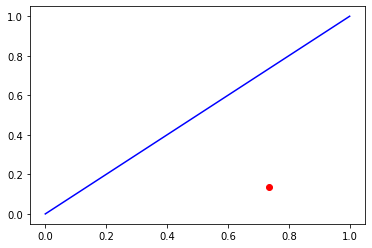

In [190]:
knn = ClasificadorVecinosProximos(11)
matriz = knn.matrizConfusion(dataset_online, VS_online.particiones[0].indicesTest, pred11)
print("-- Matriz de confusión KNN -- ONLINE_SHOPPERS -- K = 11 -- VAL. SIMPLE")
print(matriz)
knn.curvaROC()

-- Matriz de confusión KNN -- WDBC -- K = 11 -- VAL. SIMPLE
[[105   6]
 [  0  60]]


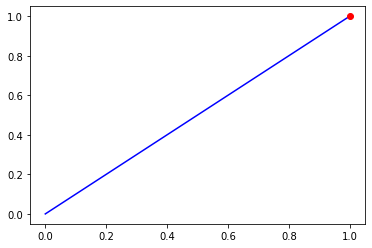

In [191]:
knn = ClasificadorVecinosProximos(11)
knn.entrenamiento(dataset_wdbc, VS_wdbc.particiones[0].indicesTrain)
pred = knn.clasifica(dataset_wdbc.datos,VS_wdbc.particiones[0].indicesTest)
matriz = knn.matrizConfusion(dataset_wdbc, VS_wdbc.particiones[0].indicesTest, pred)
print("-- Matriz de confusión KNN -- WDBC -- K = 11 -- VAL. SIMPLE")
print(matriz)
knn.curvaROC()

-- Matriz de confusión KNN -- WDBC -- K = 11 -- VAL. CRUZADA -- Nº:  1
[[70  2]
 [ 0 42]]
-- Matriz de confusión KNN -- WDBC -- K = 11 -- VAL. CRUZADA -- Nº:  2
[[72 11]
 [ 1 30]]
-- Matriz de confusión KNN -- WDBC -- K = 11 -- VAL. CRUZADA -- Nº:  3
[[70  2]
 [ 1 41]]
-- Matriz de confusión KNN -- WDBC -- K = 11 -- VAL. CRUZADA -- Nº:  4
[[73  2]
 [ 1 38]]
-- Matriz de confusión KNN -- WDBC -- K = 11 -- VAL. CRUZADA -- Nº:  5
[[68  3]
 [ 1 41]]


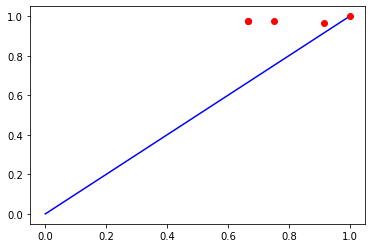

In [192]:
knn = ClasificadorVecinosProximos(11)
VC_wdbc = ValidacionCruzada(5)
VC_wdbc.creaParticiones(dataset_wdbc)
i = 1
for particion in VC_wdbc.particiones:
    knn.entrenamiento(dataset_wdbc, particion.indicesTrain)
    pred = knn.clasifica(dataset_wdbc.datos,particion.indicesTest)
    matriz = knn.matrizConfusion(dataset_wdbc, particion.indicesTest, pred)
    print("-- Matriz de confusión KNN -- WDBC -- K = 11 -- VAL. CRUZADA -- Nº: ",i)
    print(matriz)
    i += 1
knn.curvaROC()

<h4>Curvas ROC Regresión Logística</h4>

-- Matriz de confusión REG. LOG. -- ONLINE SHOPPERS -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. SIMPLE
[[1948   68]
 [1177  506]]


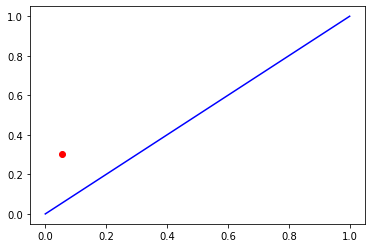

In [196]:
reg_log = ClasificadorRegresionLogistica(0.1, 100)
reg_log.entrenamiento(dataset_online, VS_online.particiones[0].indicesTrain)
pred = reg_log.clasifica(dataset_online.datos,VS_online.particiones[0].indicesTest)
matriz = reg_log.matrizConfusion(dataset_online, VS_online.particiones[0].indicesTest, pred)
print("-- Matriz de confusión REG. LOG. -- ONLINE SHOPPERS -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. SIMPLE")
print(matriz)
reg_log.curvaROC()

-- Matriz de confusión REG. LOG. -- WDBC -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. SIMPLE
[[100   2]
 [  5  64]]


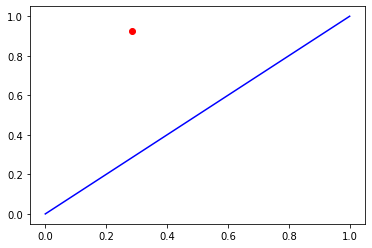

In [197]:
reg_log = ClasificadorRegresionLogistica(0.01, 100)
reg_log.entrenamiento(dataset_wdbc, VS_wdbc.particiones[0].indicesTrain)
pred = reg_log.clasifica(dataset_wdbc.datos,VS_wdbc.particiones[0].indicesTest)
matriz = reg_log.matrizConfusion(dataset_wdbc, VS_wdbc.particiones[0].indicesTest, pred)
print("-- Matriz de confusión REG. LOG. -- WDBC -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. SIMPLE")
print(matriz)
reg_log.curvaROC()

-- Matriz de confusión REG. LOG. -- ONLINE_SHOPPERS -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. CRUZADA -- Nº:  1
[[1052   46]
 [1001  367]]
-- Matriz de confusión REG. LOG. -- ONLINE_SHOPPERS -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. CRUZADA -- Nº:  2
[[1124   32]
 [ 991  319]]
-- Matriz de confusión REG. LOG. -- ONLINE_SHOPPERS -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. CRUZADA -- Nº:  3
[[1159   44]
 [ 920  343]]
-- Matriz de confusión REG. LOG. -- ONLINE_SHOPPERS -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. CRUZADA -- Nº:  4
[[1169   56]
 [ 911  330]]
-- Matriz de confusión REG. LOG. -- ONLINE_SHOPPERS -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. CRUZADA -- Nº:  5
[[1991  188]
 [ 104  183]]


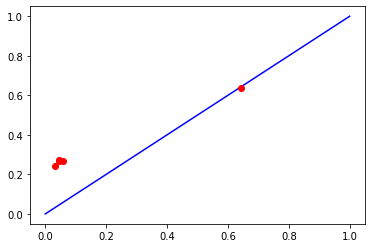

In [198]:
reg_log = ClasificadorRegresionLogistica(0.01, 100)
VC_online = ValidacionCruzada(5)
VC_online.creaParticiones(dataset_online)
i = 1
for particion in VC_online.particiones:
    reg_log.entrenamiento(dataset_online, particion.indicesTrain)
    pred = reg_log.clasifica(dataset_online.datos,particion.indicesTest)
    matriz = reg_log.matrizConfusion(dataset_online, particion.indicesTest, pred)
    print("-- Matriz de confusión REG. LOG. -- ONLINE_SHOPPERS -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. CRUZADA -- Nº: ",i)
    print(matriz)
    i += 1
reg_log.curvaROC()

-- Matriz de confusión REG. LOG. -- WDBC -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. CRUZADA -- Nº:  1
[[71  1]
 [ 1 41]]
-- Matriz de confusión REG. LOG. -- WDBC -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. CRUZADA -- Nº:  2
[[77  1]
 [ 0 36]]
-- Matriz de confusión REG. LOG. -- WDBC -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. CRUZADA -- Nº:  3
[[71  6]
 [ 1 36]]
-- Matriz de confusión REG. LOG. -- WDBC -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. CRUZADA -- Nº:  4
[[75  0]
 [ 1 38]]
-- Matriz de confusión REG. LOG. -- WDBC -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. CRUZADA -- Nº:  5
[[58  2]
 [ 2 51]]


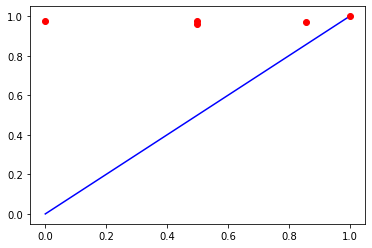

In [199]:
reg_log = ClasificadorRegresionLogistica(0.01, 100)
VC_wdbc = ValidacionCruzada(5)
VC_wdbc.creaParticiones(dataset_wdbc)
i = 1
for particion in VC_wdbc.particiones:
    reg_log.entrenamiento(dataset_wdbc, particion.indicesTrain)
    pred = reg_log.clasifica(dataset_wdbc.datos,particion.indicesTest)
    matriz = reg_log.matrizConfusion(dataset_wdbc, particion.indicesTest, pred)
    print("-- Matriz de confusión REG. LOG. -- WDBC -- n = 0.01 -- N. ÉPOCAS = 100 -- VAL. CRUZADA -- Nº: ",i)
    print(matriz)
    i += 1
reg_log.curvaROC()

<h3>Tablas de resultados</h3>

A continuación se exponen todos los resultados de las ejecuciones de Vecinos Próximos y Regresión Logísitca, tanto nuestra implementación como la de SKLearn.

<h4>Resultados Algorirmos propios</h4>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-7btt{font-weight:bold;border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-7btt">KNN</th>
    <th class="tg-7btt"></th>
    <th class="tg-7btt" colspan="2">V. Simple<br></th>
    <th class="tg-7btt" colspan="2">V. Cruzada</th>
  </tr>
  <tr>
    <td class="tg-7btt"></td>
    <td class="tg-7btt">K</td>
    <td class="tg-7btt">Normalizado</td>
    <td class="tg-amwm">Sin normalizar</td>
    <td class="tg-7btt">Normalizado<br></td>
    <td class="tg-amwm">Sin normalizar</td>
  </tr>
  <tr>
    <td class="tg-amwm" rowspan="4"><br><br><br>ONLINE</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0.153</td>
    <td class="tg-baqh">0.153</td>
    <td class="tg-baqh">-</td>
    <td class="tg-baqh">-</td>
  </tr>
  <tr>
    <td class="tg-c3ow">3</td>
    <td class="tg-c3ow">0.153</td>
    <td class="tg-baqh">-</td>
    <td class="tg-c3ow">-</td>
    <td class="tg-baqh">-</td>
  </tr>
  <tr>
    <td class="tg-c3ow">5</td>
    <td class="tg-c3ow">0.153</td>
    <td class="tg-baqh">-</td>
    <td class="tg-c3ow">-</td>
    <td class="tg-baqh">-</td>
  </tr>
  <tr>
    <td class="tg-c3ow">11</td>
    <td class="tg-c3ow">0.153</td>
    <td class="tg-baqh">-</td>
    <td class="tg-c3ow">-</td>
    <td class="tg-baqh">-</td>
  </tr>
  <tr>
    <td class="tg-7btt" rowspan="4"><br><br><br>WDBC</td>
    <td class="tg-c3ow">1<br></td>
    <td class="tg-c3ow">0.07</td>
    <td class="tg-baqh">0.029</td>
    <td class="tg-c3ow">0.049 +- 0.02</td>
    <td class="tg-baqh">0.044 +- 0.01</td>
  </tr>
  <tr>
    <td class="tg-c3ow">3</td>
    <td class="tg-c3ow">0.041<br></td>
    <td class="tg-baqh">0.047</td>
    <td class="tg-c3ow">0.035 +- 0.02<br></td>
    <td class="tg-baqh">0.035 +- 0.01</td>
  </tr>
  <tr>
    <td class="tg-c3ow">5</td>
    <td class="tg-c3ow">0.035</td>
    <td class="tg-baqh">0.029</td>
    <td class="tg-c3ow">0.035 +- 0.02</td>
    <td class="tg-baqh">0.035 +- 0.01</td>
  </tr>
  <tr>
    <td class="tg-c3ow">11</td>
    <td class="tg-c3ow">0.07<br></td>
    <td class="tg-baqh">0.053</td>
    <td class="tg-c3ow">0.037 +- 0.01</td>
    <td class="tg-baqh">0.04 +- 0.02</td>
  </tr>
</table>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-7btt{font-weight:bold;border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-7btt">Reg. Log.<br></th>
    <th class="tg-7btt">Constante Aprendizaje</th>
    <th class="tg-7btt">Num. Épocas<br></th>
    <th class="tg-amwm">V. Simple</th>
    <th class="tg-7btt">V. Cruzada</th>
  </tr>
  <tr>
    <td class="tg-amwm" rowspan="6"><br><br><br><br><br><br>ONLINE</td>
    <td class="tg-baqh">0.1</td>
    <td class="tg-baqh">10<br></td>
    <td class="tg-baqh">0.119</td>
    <td class="tg-baqh">0.616 +- 0.25</td>
  </tr>
  <tr>
    <td class="tg-c3ow">1</td>
    <td class="tg-c3ow">10</td>
    <td class="tg-baqh">0.122</td>
    <td class="tg-c3ow">0.137 +- 0.05</td>
  </tr>
  <tr>
    <td class="tg-c3ow">0.01</td>
    <td class="tg-c3ow">10</td>
    <td class="tg-baqh">0.119</td>
    <td class="tg-c3ow">0.12 +- 0.01</td>
  </tr>
  <tr>
    <td class="tg-c3ow">0.1</td>
    <td class="tg-c3ow">100</td>
    <td class="tg-baqh">0.128</td>
    <td class="tg-c3ow">0.119 +- 0.009</td>
  </tr>
  <tr>
    <td class="tg-baqh">1<br></td>
    <td class="tg-baqh">100</td>
    <td class="tg-baqh">0.435</td>
    <td class="tg-baqh">0.13 +- 0.009</td>
  </tr>
  <tr>
    <td class="tg-baqh">0.01</td>
    <td class="tg-baqh">100</td>
    <td class="tg-baqh">0.178</td>
    <td class="tg-baqh">0.55 +- 0.22</td>
  </tr>
  <tr>
    <td class="tg-7btt" rowspan="6"><br><br><br><br>WDBC</td>
    <td class="tg-c3ow">0.1</td>
    <td class="tg-c3ow">10</td>
    <td class="tg-baqh">0.082</td>
    <td class="tg-c3ow">0.15 +- 0.05</td>
  </tr>
  <tr>
    <td class="tg-c3ow">1</td>
    <td class="tg-c3ow">10</td>
    <td class="tg-baqh">0.158</td>
    <td class="tg-c3ow">0.22 +- 0.08</td>
  </tr>
  <tr>
    <td class="tg-c3ow">0.01</td>
    <td class="tg-c3ow">10</td>
    <td class="tg-baqh">0.351<br></td>
    <td class="tg-c3ow">0.076 +- 0.02</td>
  </tr>
  <tr>
    <td class="tg-c3ow">0.1</td>
    <td class="tg-c3ow">100</td>
    <td class="tg-baqh">0.105</td>
    <td class="tg-c3ow">0.19 +- 0.09</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">100</td>
    <td class="tg-baqh">0.07</td>
    <td class="tg-baqh">0.093 +- 0.03</td>
  </tr>
  <tr>
    <td class="tg-baqh">0.01</td>
    <td class="tg-baqh">100</td>
    <td class="tg-baqh">0.119</td>
    <td class="tg-baqh">0.13 +- 0.08</td>
  </tr>
</table>

<h4>Resultados SKLearn</h4>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-7btt{font-weight:bold;border-color:inherit;text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-7btt">KNN</th>
    <th class="tg-7btt">K</th>
    <th class="tg-7btt">V. Simple<br></th>
    <th class="tg-7btt">V. Cruzada</th>
  </tr>
  <tr>
    <td class="tg-7btt" rowspan="4"><br><br>ONLINE</td>
    <td class="tg-c3ow">1<br></td>
    <td class="tg-c3ow">0.155<br></td>
    <td class="tg-c3ow">-<br></td>
  </tr>
  <tr>
    <td class="tg-c3ow">3</td>
    <td class="tg-c3ow">0.133</td>
    <td class="tg-c3ow">-</td>
  </tr>
  <tr>
    <td class="tg-c3ow">5</td>
    <td class="tg-c3ow">0.128</td>
    <td class="tg-c3ow">-</td>
  </tr>
  <tr>
    <td class="tg-c3ow">11</td>
    <td class="tg-c3ow">0.118</td>
    <td class="tg-c3ow">-</td>
  </tr>
  <tr>
    <td class="tg-7btt" rowspan="4"><br><br><br>WDBC</td>
    <td class="tg-c3ow">1<br></td>
    <td class="tg-c3ow">-</td>
    <td class="tg-c3ow">0.049 +- 0.02</td>
  </tr>
  <tr>
    <td class="tg-c3ow">3</td>
    <td class="tg-c3ow">-</td>
    <td class="tg-c3ow">0.042 +- 0.02</td>
  </tr>
  <tr>
    <td class="tg-c3ow">5</td>
    <td class="tg-c3ow">-</td>
    <td class="tg-c3ow">0.035 +- 0.01</td>
  </tr>
  <tr>
    <td class="tg-c3ow">11</td>
    <td class="tg-c3ow">-</td>
    <td class="tg-c3ow">0.039 +- 0.02</td>
  </tr>
</table>

| Reg. Log 	| Num. Épocas 	| Constante aprendizaje 	| V. Simple 	|   V. cruzada  	|
|:--------:	|:-----------:	|:---------------------:	|-----------	|:-------------:	|
|  ONLINE  	|   1000000   	|      POR DEFECTO      	|   0.117   	| 0.177 +- 0.01 	|
|   WDBC   	|   1000000   	|      POR DEFECTO      	|   0.023   	| 0.022 +- 0.01 	|

<h3>Conclusiones</h3>